In [1]:
import pathlib

import pandas as pd

from utils import (get_model_predictions, 
                   get_ribo_seq_data, 
                   get_misannotated_lncrnas, 
                   get_cncrnadb_data)
from plotting import get_ribo_seq_venn, intersection_dl_models_venn, cncrnadb_venn

In [2]:
DATA_DIR = pathlib.Path('../data')
FIG_DIR = pathlib.Path('../figures')

CNN_PREDS_DIR = DATA_DIR / 'model_predictions' / 'cnn_29_test_predict_hist.csv'
LSTM_PREDS_DIR = DATA_DIR / 'model_predictions' / 'lstm_29_test_predict_hist.csv'
TRNF_PREDS_DIR = DATA_DIR / 'model_predictions' / 'transformer_29_test_hist.csv'

RIBO_SEQ_DIR = DATA_DIR / 'ribo_seq' / 'results_from_db.txt'

CNCRNADB_DIR = DATA_DIR / 'cncrnadb' / 'cncRNAdb.txt'

LNCRNA_ID_MAP_DIR = DATA_DIR / 'id_mappings' / 'mart_export.txt'



MEAN_CUTOFF = 0.6
STD_CUTOFF = 0.4

DL_I = 'Transformer,\nCNN, LSTM\n Intersection'
DL_U = 'Transformer,\n CNN, LSTM\n  Union'

In [3]:
# all model predictions
cnn_preds = get_model_predictions(CNN_PREDS_DIR, LNCRNA_ID_MAP_DIR)
lstm_preds = get_model_predictions(LSTM_PREDS_DIR, LNCRNA_ID_MAP_DIR)
transf_preds = get_model_predictions(TRNF_PREDS_DIR, LNCRNA_ID_MAP_DIR)
# misannotated lncRNAs
cnn_m_lncrnas = get_misannotated_lncrnas(cnn_preds, MEAN_CUTOFF, STD_CUTOFF)
lstm_m_lncrnas = get_misannotated_lncrnas(lstm_preds, MEAN_CUTOFF, STD_CUTOFF)
transf_m_lncrnas = get_misannotated_lncrnas(transf_preds, MEAN_CUTOFF, STD_CUTOFF)

# DL Intersection

In [4]:
cnn_m_lncrnas.columns

Index(['id', 'gold_lab', 'mean', 'std', 'ids', 'Gene stable ID',
       'Transcript stable ID', 'Transcript stable ID version',
       'Protein stable ID', 'EntrezGene transcript name ID',
       'NCBI gene (formerly Entrezgene) ID'],
      dtype='object')

In [7]:
import numpy as np

In [11]:
cnn = cnn_m_lncrnas[['id', 'mean', 'std']]
lstm = lstm_m_lncrnas[['id', 'mean', 'std']]
transf = transf_m_lncrnas[['id', 'mean', 'std']]

merged = cnn.merge(lstm, how='outer', on='id', suffixes=('_cnn', '_lstm'))
merge2 = merged.merge(transf, how='outer', on='id', suffixes=('_', '_transformer'))
merge2['inCNN'] = [0 if pd.isnull(e) else 1 for e in merge2['mean_cnn']]
merge2['inLSTM'] = [0 if pd.isnull(e) else 1 for e in merge2['mean_lstm']]
merge2['inTransformer'] = [0 if pd.isnull(e) else 1 for e in merge2['mean']]

merge2.to_csv('all_preds.csv')

In [4]:
save_dir = FIG_DIR / 'dl_intersections_misannot.pdf'
intersection_dl_models_venn(set(cnn_m_lncrnas['Gene stable ID']),
                            set(lstm_m_lncrnas['Gene stable ID']), 
                            set(transf_m_lncrnas['Gene stable ID']),
                            save=True, 
                            save_dir=save_dir)

# Ribo-seq

In [5]:
ribo = get_ribo_seq_data(RIBO_SEQ_DIR)
ribo

Sorf ID Chromosome  Sorf length  \
30        andreev_2015:10029          1           19   
32       andreev_2015:100724         10           33   
33       andreev_2015:100725         10           36   
34       andreev_2015:100727         10           40   
35       andreev_2015:100730         10           48   
...                      ...        ...          ...   
2626000      zur_2016:999897          7           31   
2626001      zur_2016:999898          7           24   
2626002      zur_2016:999899          7           29   
2626003      zur_2016:999961          7           16   
2626004      zur_2016:999962          7           13   

                                       Transcript sequence Annotation  \
30       CTGGATCACCTGCACAGCCTGGGTATCATTTACAGAGACCTCAAGC...     lncrna   
32       CTGGGCCCCTCGGGCCCATCAGAGGAGAACTTCGATATGGAGGCTT...     lncrna   
33       CTGGAGGACCTGGGCCCCTCGGGCCCATCAGAGGAGAACTTCGATA...     lncrna   
34       GTGCTTGGGGTCCTGGAGGACCTGGGCCCCTCGGGCCCATCAGAGG...     lncrna   
35       TTGGATGAGGTCATCTTCTCCTATGTGCTTGGGGTCCTGGAGGACC...     lncrna   
...                                                    ...        ...   
2626000  ATGTGGATGGCCAAACCCACATGTTATTTGGCTCTGACCGGATGGA...     lncrna   
2626001  GTGGATGGCCAAACCCACATGTTATTTGGCTCTGACCGGATGGAGC...     lncrna   
2626002  ATGGCCAAACCCACATGTTATTTGGCTCTGACCGGATGGAGCTGCT...     lncrna   
2626003   ATGAAGCCTTTGAAGTGCCAGTCTATGAAGAGGCCGTGGTGGGACTAG     lncrna   
2626004            TTGAAGTGCCAGTCTATGAAGAGGCCGTGGTGGGACTAG     lncrna   

                      Biotype  RPF coverage  RPF coverage uniformity  \
30            retained_intron          0.28                    -0.21   
32       processed_transcript          0.39                     0.09   
33       processed_transcript          0.41                     0.01   
34       processed_transcript          0.42                     0.10   
35       processed_transcript          0.41                     0.03   
...                       ...           ...                      ...   
2626000       retained_intron          0.57                    -0.92   
2626001       retained_intron          0.71                    -0.41   
2626002       retained_intron          0.56                    -1.16   
2626003  processed_transcript          0.65                    -0.69   
2626004  processed_transcript          0.59                    -0.67   

        overlap with PC exons Ensembl transcript ID  Rltm min Rchx  \
30                        Yes       ENST00000474934            NaN   
32                        Yes       ENST00000477994            NaN   
33                        Yes       ENST00000477994            NaN   
34                        Yes       ENST00000477994            NaN   
35                        Yes       ENST00000477994            NaN   
...                       ...                   ...            ...   
2626000                   Yes       ENST00000473649            NaN   
2626001                   Yes       ENST00000473649            NaN   
2626002                   Yes       ENST00000473649            NaN   
2626003                   Yes       ENST00000471161            NaN   
2626004                   Yes       ENST00000471161            NaN   

         FLOSS score Floss-Classification  Orfscore Peak shift  PhastCon  \
30          0.171793                 Good  4.919491        NaN    0.9706   
32          0.160567                 Good  6.931582        NaN    0.8456   
33          0.144048                 Good  7.027359        NaN    0.8560   
34          0.146371                 Good  7.194900        NaN    0.8674   
35          0.101420                 Good  7.296097        NaN    0.8486   
...              ...                  ...       ...        ...       ...   
2626000     0.130168                 Good -9.666241        NaN    0.6213   
2626001     0.131316                 Good -9.660588        NaN    0.6828   
2626002     0.095411                 Good -9.660588        NaN    0.6325   
26260

In [6]:
dl_ids = set(cnn_preds['ids'])
ribo_ids = set(ribo['Ensembl transcript ID'])
masterIds = set.intersection(dl_ids, ribo_ids)
# dl_u = get_union_dl_models(cnn_m_lncrnas, lstm_m_lncrnas, transf_m_lncrnas, 'ids', masterIds)
dl_u = set.union(set(cnn_m_lncrnas['ids']),
                 set(lstm_m_lncrnas['ids']),
                 set(transf_m_lncrnas['ids']))

print(f'DL models contain {len(dl_ids)} RNAs')
print(f'Ribo-seq data contains {len(ribo_ids)} RNAs')
print(f'{len(masterIds)} RNAs are present in both datasets')

DL models contain 26727 RNAs
Ribo-seq data contains 23537 RNAs
1714 RNAs are present in both datasets


In [7]:
floss = ribo[(ribo['Floss-Classification'] == 'Good')]
floss = set(floss.loc[floss['Ensembl transcript ID'].isin(masterIds)]['Ensembl transcript ID'])

orfscore = ribo[(ribo['Orfscore'] > 6)]
orfscore = set(orfscore.loc[orfscore['Ensembl transcript ID'].isin(masterIds)]['Ensembl transcript ID'])

phylop = ribo[(ribo['PhyloP'] > 4)]
phylop = set(phylop.loc[phylop['Ensembl transcript ID'].isin(masterIds)]['Ensembl transcript ID'])

In [8]:
save_dir = FIG_DIR / 'union_floss.pdf'
get_ribo_seq_venn(dl_u, floss, DL_U, 'Floss', save=True, save_dir=save_dir)

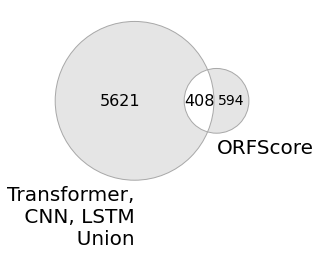

In [10]:
save_dir = FIG_DIR / 'union_orfscore.pdf'
get_ribo_seq_venn(dl_u, orfscore, DL_U, 'ORFScore', save=True, save_dir=save_dir, circle_number_size= [16, 14, 16])

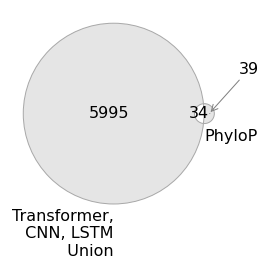

In [14]:
# save_dir = FIG_DIR / 'union_phylop.pdf'
# get_ribo_seq_venn(dl_u, phylop, DL_U, 'PhyloP', save=True, save_dir=save_dir, circle_number_size=[14, 14, 2])
import matplotlib.pyplot as plt
from matplotlib_venn import (venn2, venn2_circles, venn2_unweighted, venn3, venn3_circles)
import numpy as np
circle_number_size = [16, 0, 16]

plt.figure(figsize=(4,4))
out = venn2((dl_u, phylop), 
            (DL_U, 'PhyloP'),
            set_colors=('silver', 'silver'), )
            # alpha = 0.8)
venn2_circles((dl_u, phylop), 
            linestyle='-', 
            linewidth=1, 
            color='darkgrey')
for text in out.set_labels:
    text.set_fontsize(16)
for i, text in enumerate(out.subset_labels):
    text.set_fontsize(circle_number_size[i])

plt.annotate('39', xy=out.get_label_by_id('010').get_position() + np.array([0, 0]), 
             xytext=(40,40), ha='center',
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->',connectionstyle='arc',color='gray'), fontsize=16)
save_dir = FIG_DIR / 'union_phylop.pdf'
plt.savefig(save_dir, dpi=200, bbox_inches='tight')

# cncRNAdb

In [15]:
cnc = get_cncrnadb_data(CNCRNADB_DIR)
cnc

cncRNA_id     type            name          gene_id chromosome  \
1     CNC_N_000002  circRNA      circGprc5a  ENSG00000013588         12   
2     CNC_N_000003  circRNA        circLgr4  ENSG00000205213         11   
3     CNC_N_000005  circRNA       circ-NCX1  ENSG00000183023          2   
4     CNC_N_000007  circRNA  hsa_circ_01271  ENSG00000164050          3   
5     CNC_N_000008  circRNA  hsa_circ_04264  ENSG00000132912          5   
...            ...      ...             ...              ...        ...   
1855  CNC_N_001502     rRNA           SHLP6  ENSG00000210082         MT   
1856  CNC_N_001503     rRNA           SHLP5  ENSG00000210082         MT   
1857  CNC_N_001504     rRNA           SHLP4  ENSG00000210082         MT   
1858  CNC_N_001811   lncRNA           APELA  ENSG00000248329          4   
1859  CNC_N_001812     rRNA             HN1  ENSG00000256618         17   

     start_locus  end_locus strand peptide_length  \
1       12891559   12917937      +             11   
2       27365961   27472790      -             19   
3       40097270   40611053      -              0   
4       48403854   48430086      -             18   
5      150708440  150759109      -             13   
...          ...        ...    ...            ...   
1855        2992       3051      +             20   
1856        2785       2856      +             24   
1857        2446       2524      -             26   
1858   164877178  164898965      +             32   
1859    22523111   22524663      +             24   

                                                 tissue      organism  \
1                              Bladder cancer stem cell  Homo sapiens   
2                       293T cell;Colorectal tumor cell  Homo sapiens   
3                                          HEK-293 cell  Homo sapiens   
4                                                 Brain  Homo sapiens   
5                                                 Brain  Homo sapiens   
...                                                 ...           ...   
1855  Hela cell;Heart;Liver;Brain;Kidney;Spleen;Pros...  Homo sapiens   
1856                                          Hela cell  Homo sapiens   
1857  Hela cell;Liver;Brain;Kidney;Spleen;Prostate;T...  Homo sapiens   
1858   Xenopus laevis embryo;Human embryonic stem cells  Homo sapiens   
1859                                           F11 cell  Homo sapiens   

                           genomics                  peptide_sequence  
1     human Dec. 2013 (GRCh38/hg38)                       FDTKPMNLCGR  
2     human Dec. 2013 (GRCh38/hg38)               LQTASDESYKDPTNIQLSK  
3     human Dec. 2013 (GRCh38/hg38)                               NaN  
4     human Dec. 2013 (GRCh38/hg38)                MEQLWPSSPASPSMCSGK  
5     human Dec. 2013 (GRCh38/hg38)                     MQQQSTMSWQNLK  
...                             ...                               ...  
1855  human Dec. 2013 (GRCh38/hg38)              MLDQDIPMVQPLLKVRLFND  
1856  human Dec. 2013 (GRCh38/hg38)          MAPRGFSCLLLLTSEIDLPVKRRA  
1857  human Dec. 2013 (GRCh38/hg38)        MLEVMFLVNRRGKICRVPFTFFNLSL  
1858  human Dec. 2013 (GRCh38/hg38)  QRPVNLTMRRKLRKHNCLQRRCMPLHSRVPFP  
1859  human Dec. 2013 (GRCh38/hg38)          MAPRGFSCLLLLTSEIDLPVKRRA  

[1859 rows x 13 columns]

In [16]:
dl_ids = set(cnn_preds['Gene stable ID'])
cnc_ids = set(cnc['gene_id'])
masterIds = set.intersection(dl_ids, cnc_ids)
print(f'{len(dl_ids)} ids in DL\n{len(cnc_ids)} ids in cncRNAdb\n{len(masterIds)} ids in both\n')
cnc_ = set(cnc.loc[cnc['gene_id'].isin(masterIds)]['gene_id'])
dl_u = set.union(set(cnn_m_lncrnas['Gene stable ID']),
                 set(lstm_m_lncrnas['Gene stable ID']),
                 set(transf_m_lncrnas['Gene stable ID']))

15446 ids in DL
1277 ids in cncRNAdb
442 ids in both



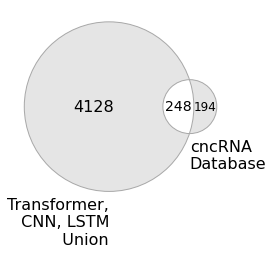

In [18]:
save_dir = FIG_DIR / 'dl_union_cncRNAdb.pdf'
cncrnadb_venn(dl_u, cnc_, DL_U, save=True, save_dir=save_dir, circle_name_size=16, circle_number_size=[16, 12, 14])